In [1]:
#https://www.relataly.com/stock-price-prediction-multi-output-regression-using-neural-networks-in-python/5800/

#https://github.com/flo7up/relataly-public-python-tutorials/blob/master/006%20Time%20Series%20Forecasting%20-%20Multi-Output%20Regression.ipynb

# Step #1 Load the Data

In [1]:
# Time Series Forecasting - Multi-output Regression for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
import time
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates

from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data

import tensorflow as tf
from tensorflow.keras.models import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training


import keras_tuner as kt
from keras_tuner.engine.hyperparameters import HyperParameters
 
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.callbacks import EarlyStopping
# from keras.layers import Flatten,Dropout    
    
import seaborn as sns

from tensorflow.keras.models import load_model
import joblib

# check the tensorflow version and the number of available GPUs
# print('Tensorflow Version: ' + tf.__version__)
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs:", len(physical_devices))



In [57]:
# ab_path = "../data/SET50-Daily-Y09-Now.csv"
# asset_name='SET50'

ab_path = "../data/SPY-Daily-Y09-Now.csv"
asset_name='SP500-SPY'

start_date='2012-01-01'
# start_date='2022-01-01'
end_date='2022-12-31'


date_col='Date'
prediction_col='EMA1'
# feature_cols=['Price','EMA1','MACD','RSI']
feature_cols=['EMA1']

main_obj_metric='mean_absolute_error'
main_loss='mean_absolute_error'

split_way=2

input_sequence_length =60 #60 #120
output_sequence_length =10  # 10 #20
train_ratio=0.8

n_epochs = 100  #100
n_batch_size = 32
n_early=10

model_path='models'

tune_folder=f'{prediction_col}_{input_sequence_length}To{output_sequence_length}_{asset_name}'

seed=98

#Tuning
mx_step=3  #3

min_drop=0.0
max_drop=0.3
step_drop=0.1

ratio_traial_max=0.8  #0.7/0.8
print(tune_folder)

EMA1_60To10_SP500-SPY


In [13]:
df=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
df.rename(columns={'Date/Time':date_col},inplace=True)
df.drop(columns=['Ticker'],inplace=True)
allCols=list(df.columns)
print(allCols)

['Date', 'Price', 'EMA1', 'EMA2', 'EMA3', 'MACD', 'SIGNAL', 'RSI', 'RSI-MA']


In [14]:
df[date_col]=df[date_col].apply( lambda  dx :  datetime(dx.year,dx.month,dx.day ))
df.set_index(date_col,inplace=True)
df=df.loc[start_date:end_date,:]
df=df[feature_cols]
print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-03 to 2022-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EMA1    251 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB
None


,EMA1
Date,
2022-12-23,386.73
2022-12-27,385.76
2022-12-28,384.11
2022-12-29,383.99
2022-12-30,383.70


# Step #2 Exploring the Data

In [15]:
ncols = 1
nrows = len(feature_cols)

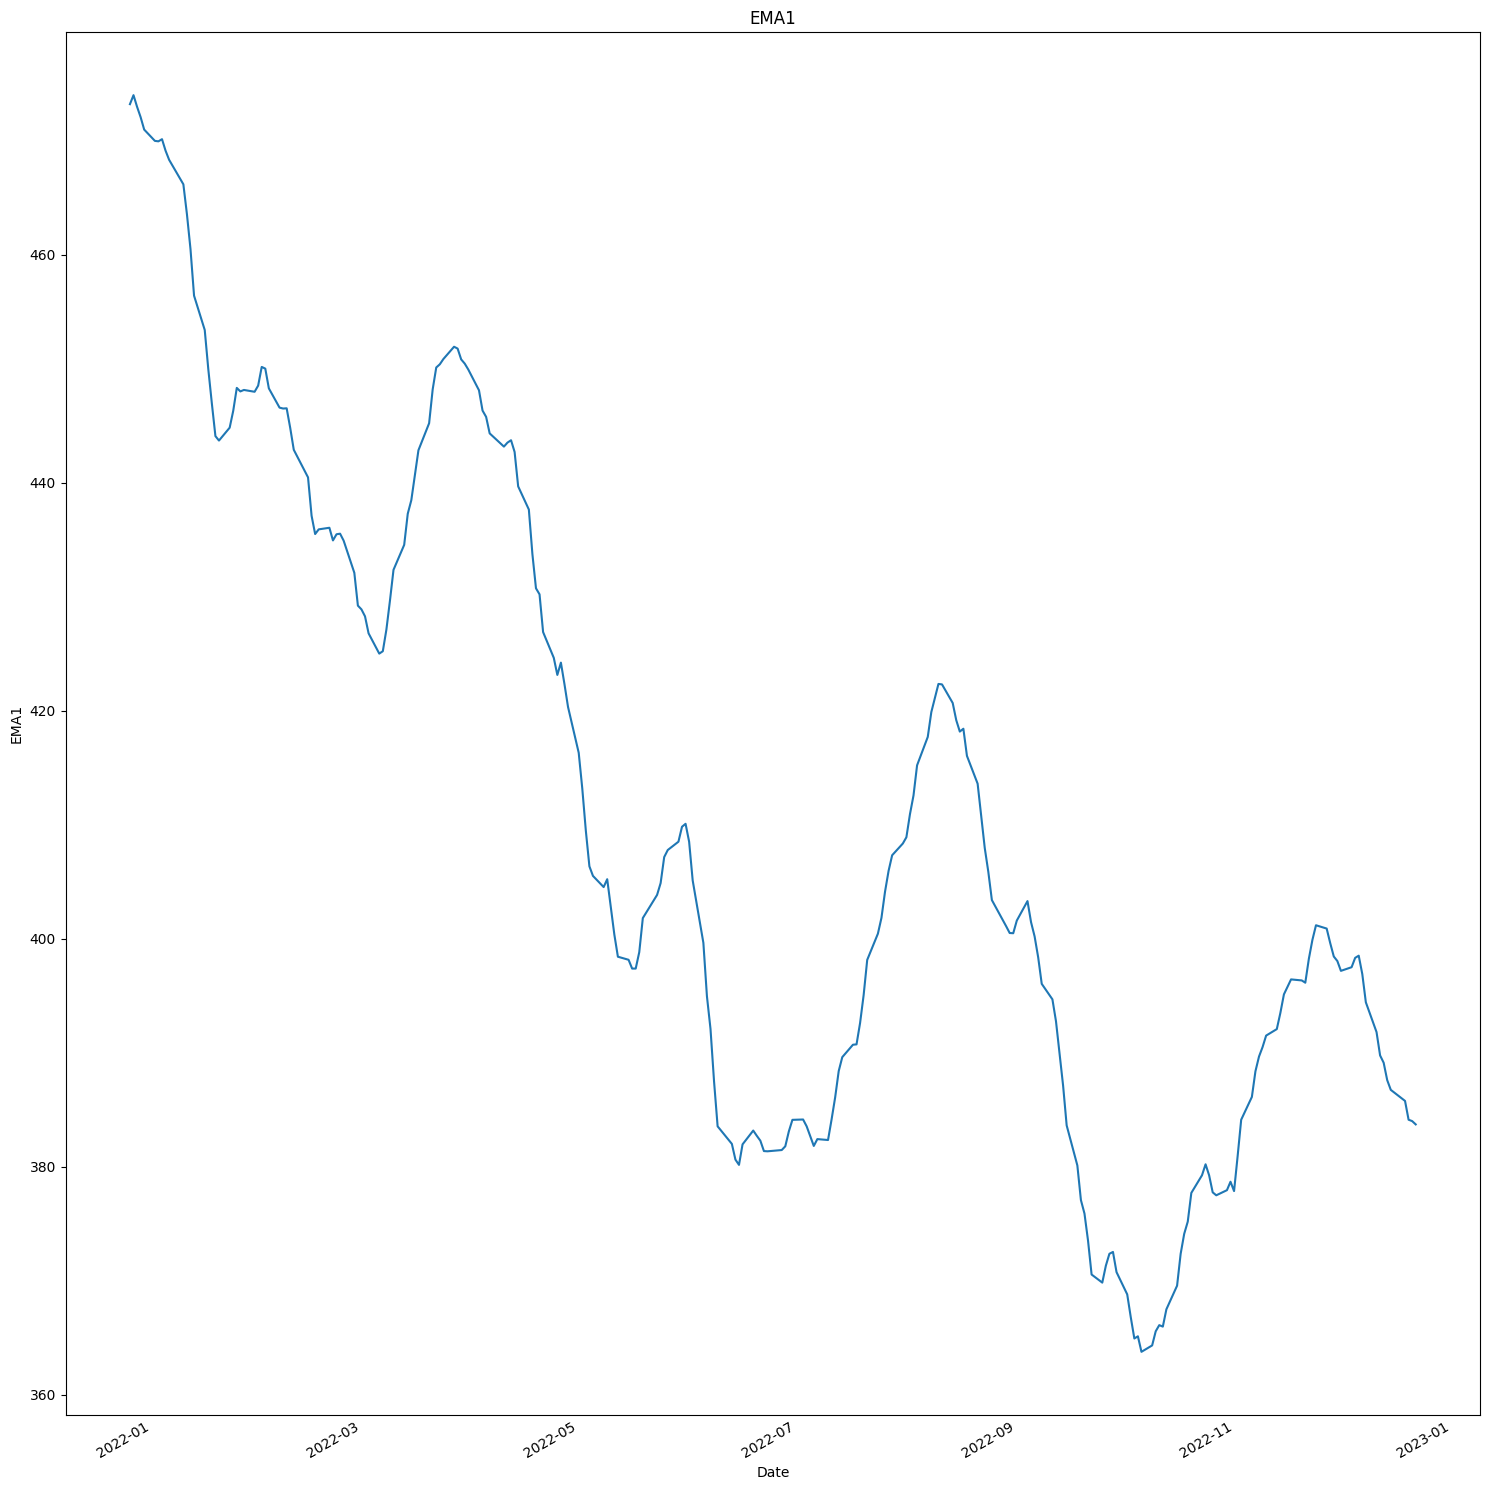

In [16]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(15, 15))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.title.set_text(df.columns[i])
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [17]:
# Indexing Batches
df_train = df.sort_values(by=[date_col]).copy()
df_train.shape

(251, 1)

In [18]:
def prepare_data(df):

    # List of considered Features
    FEATURES = feature_cols

    print(f'FEATURE LIST To Predict {prediction_col}')
    print([f for f in FEATURES])

    #Create the dataset with features and filter the data to the list of FEATURES"
    df_filter = df[FEATURES]
    
    print("Convert the data to numpy values")
    np_filter_unscaled = np.array(df_filter)
    np_filter_unscaled = np.reshape(np_filter_unscaled, (df_filter.shape[0], -1))
    print(np_filter_unscaled.shape)
    
    np_c_unscaled = np.array(df[prediction_col]).reshape(-1, 1)
    print(np_c_unscaled.shape)
    
    return np_filter_unscaled, np_c_unscaled

np_filter_unscaled, np_c_unscaled = prepare_data(df_train)   


print("Feature Data",np_filter_unscaled.shape)
print(np_filter_unscaled[:3])
print("Prediction Data",np_c_unscaled.shape)
print(np_c_unscaled[:3])

FEATURE LIST To Predict EMA1
['EMA1']
Convert the data to numpy values
(251, 1)
(251, 1)
Feature Data (251, 1)
[[473.2 ]
 [473.99]
 [472.97]]
Prediction Data (251, 1)
[[473.2 ]
 [473.99]
 [472.97]]


In [19]:
print(f"{input_sequence_length} = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction")
print(f"{output_sequence_length} = The output sequence length is the number of steps that the neural network predicts")

#How much ratio to split
index_Close = df_train.columns.get_loc(prediction_col)
print(f"Prediction Index = {index_Close}")

# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_length = math.ceil(np_filter_unscaled.shape[0] * train_ratio)
print(f"{train_ratio} = {train_data_length} Split the training data into train and train data sets")

20 = Set the input_sequence_length length - this is the timeframe used to make a multiple prediction
5 = The output sequence length is the number of steps that the neural network predicts
Prediction Index = 0
0.8 = 201 Split the training data into train and train data sets


In [20]:
print("Creating a separate scaler that works on a single column for scaling predictions")
print("Scale each feature to a range between 0 and 1")
scaler_train = MinMaxScaler()
print("Create a separate scaler for a single column")
scaler_pred = MinMaxScaler()


if split_way==1:
    print("Way#1 scale entire data and split data")   
    
    np_scaled = scaler_train.fit_transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_c_unscaled)
    
    print("All Data scaled for creating train and test data")    
    print(np_scaled.shape,np_scaled_c.shape)
    print(np_scaled_c[:5],np_scaled_c[:5])
    
    # Create the training and test data
    train_data =np_scaled[0:train_data_length, :]
    test_data = np_scaled[train_data_length - input_sequence_length:, :]

else:
    print("#Way#2 split data and apply  only train to scale")
    
    train_data = np_filter_unscaled[0:train_data_length, :]
    test_data = np_filter_unscaled[train_data_length - input_sequence_length:, :]

    np_PredictVal_unScaled=np_c_unscaled[0:train_data_length]
    
    print("Train Data to be scaled") 
    print(train_data.shape,np_PredictVal_unScaled.shape)
    print(train_data[:5],np_PredictVal_unScaled[:5])
    
    train_data=scaler_train.fit_transform(train_data)
    test_data=scaler_train.transform(test_data)
    
    print(f"For predict test that take the past {input_sequence_length} train value to predict the first test value")
    np_scaled=scaler_train.transform(np_filter_unscaled)
    np_scaled_c = scaler_pred.fit_transform(np_PredictVal_unScaled)
    
    print("Predict val data(Scaled from Train data")
    print(np_scaled_c.shape)
    print(np_scaled_c[:3])
print("=========================================")       
print("Scaled data completely")
print("train and test data")
print(train_data.shape,test_data.shape)
print(train_data[:3])
print(test_data[:3])



Creating a separate scaler that works on a single column for scaling predictions
Scale each feature to a range between 0 and 1
Create a separate scaler for a single column
#Way#2 split data and apply  only train to scale
Train Data to be scaled
(201, 1) (201, 1)
[[473.2 ]
 [473.99]
 [472.97]
 [472.06]
 [470.97]] [[473.2 ]
 [473.99]
 [472.97]
 [472.06]
 [470.97]]
For predict test that take the past 20 train value to predict the first test value
Predict val data(Scaled from Train data
(201, 1)
[[0.99283382]
 [1.        ]
 [0.99074746]]
Scaled data completely
train and test data
(201, 1) (70, 1)
[[0.99283382]
 [1.        ]
 [0.99074746]]
[[0.2118106 ]
 [0.18015239]
 [0.14831277]]


In [21]:
print("The RNN needs data with the format of [samples, time steps, features]")
def partition_dataset(input_sequence_length, output_sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(input_sequence_length, data_len - output_sequence_length):
        x.append(data[i-input_sequence_length:i,:]) #contains input_sequence_length values 0-input_sequence_length * columns
        y.append(data[i:i + output_sequence_length, index_Close]) #contains the prediction values for validation ,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

The RNN needs data with the format of [samples, time steps, features]


In [22]:
print(f"Here, we create {len(train_data)} samples, input_sequence_length time steps per sample, and f features")

print("Generate training data and test data")
x_train, y_train = partition_dataset(input_sequence_length, output_sequence_length, train_data)
x_test, y_test = partition_dataset(input_sequence_length, output_sequence_length, test_data)

print("The shapes: the result is: (rows, training_sequence, features) (prediction value, )")
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)



Here, we create 201 samples, input_sequence_length time steps per sample, and f features
Generate training data and test data
The shapes: the result is: (rows, training_sequence, features) (prediction value, )
(176, 20, 1) (176, 5)
(45, 20, 1) (45, 5)


# Step #4 Model Training

# Paramterter Network

In [23]:
# Configure the neural network model
# tf.random.set_seed(7)

model = Sequential()
n_output_neurons = output_sequence_length
  
inputshape_Timestamps= x_train.shape[1]
no_feature=x_train.shape[2]
#x_train.shape[1] * x_train.shape[2]
neuron_number =inputshape_Timestamps * no_feature


step_neuron=int(neuron_number)
max_neuron=int(step_neuron*mx_step)
print(f"Train Row : {x_train.shape[0]} to predict future {n_output_neurons}")
print(f"Total NN : {neuron_number}= {inputshape_Timestamps}(backward step) x {no_feature} (features) with step up {step_neuron} until {max_neuron}")
    


neuron_list = [*range(neuron_number, max_neuron+step_neuron, step_neuron)]

drop_list=np.arange (min_drop, max_drop ,step_drop)
drop_list=np.append(drop_list,[max_drop])

allPosComb=len(neuron_list)*len(drop_list)
print(f"{neuron_list} and {drop_list}")
print(f"all combination : {len(neuron_list)} x {len(drop_list)} = {allPosComb}")

nMax_trials=int(allPosComb*ratio_traial_max)
if nMax_trials<10:
    nMax_trials=10
nExecutions_per_trial=3

print("MAx run :" ,nMax_trials , "each trail run to essemble ",nExecutions_per_trial)

Train Row : 176 to predict future 5
Total NN : 20= 20(backward step) x 1 (features) with step up 20 until 40
[20, 40] and [0.  0.1 0.2 0.3]
all combination : 2 x 4 = 8
MAx run : 4 each trail run to essemble  3


# NetWork Architeture Model Design

In [30]:
# Way one layer
def build_model_way(hp):
    
    model = Sequential()

    model.add(LSTM( hp.Int('input_unit',min_value=neuron_number ,max_value=max_neuron,step=step_neuron) \
                   , return_sequences=False, input_shape=(inputshape_Timestamps,no_feature)))
    
    model.add(Dropout(hp.Float('Dropout_rate',min_value=min_drop,max_value=max_drop,step=step_drop))) 
    
    model.add(Dense(n_output_neurons))

    model.compile(optimizer="adam", loss=main_loss, metrics=[main_obj_metric,'mean_squared_error'])
    return model

In [31]:
buildtime = datetime.now().strftime('%d%m%y_%H%M')
project_model=f"OneVarIn-MultiOut_{buildtime}"
print(project_model)


t_Start=time.time()

print(f"Start tund at {datetime.now()}")

one-var_multi-output_140123_2356
Start tund at 2023-01-14 23:56:53.017397


In [32]:
early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)

tuner = kt.BayesianOptimization(
# tuner = kt.Hyperband(
# tuner= kt.RandomSearch(
        build_model_way,
        objective=main_obj_metric,
        max_trials=nMax_trials,
        seed=seed,
        executions_per_trial=nExecutions_per_trial,
        directory=f"tuning/{tune_folder}/",
        project_name= project_model
   
        )
tuner.search(x_train, y_train, batch_size=n_batch_size, epochs=n_epochs,
                        validation_data=(x_test, y_test),
                        shuffle=False,verbose=1,callbacks=[early_stop])



Trial 4 Complete [00h 00m 18s]
mean_absolute_error: 0.11902790019909541

Best mean_absolute_error So Far: 0.09324138859907787
Total elapsed time: 00h 01m 14s
INFO:tensorflow:Oracle triggered exit


In [35]:
print("Space to search")
tuner.search_space_summary()
print(f"Suumary of {nMax_trials}")
tuner.results_summary()

Space to search
Search space summary
Default search space size: 2
input_unit (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 20, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
Suumary of 4
Results summary
Results in tuning/oneInput_multiOut_SET50/one-var_multi-output_140123_2356
Showing 10 best trials
Trial summary
Hyperparameters:
input_unit: 40
Dropout_rate: 0.0
Score: 0.09324138859907787
Trial summary
Hyperparameters:
input_unit: 40
Dropout_rate: 0.2
Score: 0.11902790019909541
Trial summary
Hyperparameters:
input_unit: 20
Dropout_rate: 0.1
Score: 0.15095599492390951
Trial summary
Hyperparameters:
input_unit: 20
Dropout_rate: 0.2
Score: 0.1834762543439865


In [36]:
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execution : ',round(t_elapsed,2)) 
print(datetime.now())

Total execution :  0.03
2023-01-14 23:58:56.146599


In [37]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model=tuner.get_best_models(num_models=1)[0]

print(best_hps.values)

model.summary()

{'input_unit': 40, 'Dropout_rate': 0.0}
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40)                6720      
                                                                 
 dropout (Dropout)           (None, 40)                0         
                                                                 
 dense (Dense)               (None, 5)                 205       
                                                                 
Total params: 6,925
Trainable params: 6,925
Non-trainable params: 0
_________________________________________________________________


In [38]:
print("build model from  the best tuning")
model = tuner.hypermodel.build(best_hps)
print(model.summary())

build model from  the best tuning
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                6720      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                 205       
                                                                 
Total params: 6,925
Trainable params: 6,925
Non-trainable params: 0
_________________________________________________________________
None


# Training the TUNED Model 

In [39]:
print(f"Training the TUNE Model")
t_Start=time.time()
print(datetime.now())

if n_early==0:

 history = model.fit(x_train, y_train, 
                batch_size=n_batch_size,
                epochs=n_epochs,
                shuffle=False,
                validation_data=(x_test, y_test),
                verbose=2
               )
else:
    early_stop = EarlyStopping(monitor='loss', patience=n_early, verbose=1)
                    
    history = model.fit(x_train, y_train, 
                    batch_size=n_batch_size, 
                    epochs=n_epochs,
                    shuffle=False,
                    validation_data=(x_test, y_test),
                    verbose=2,callbacks=[early_stop]
                   )
        
t_End=time.time()
t_elapsed=(t_End-t_Start)/60/60
print('Total execute making report : ',round(t_elapsed,2)) 
print(datetime.now())

Training the TUNE Model
2023-01-14 23:59:04.238808
Epoch 1/10
6/6 - 4s - loss: 0.4421 - mean_absolute_error: 0.4421 - mean_squared_error: 0.2597 - val_loss: 0.1971 - val_mean_absolute_error: 0.1971 - val_mean_squared_error: 0.0462 - 4s/epoch - 653ms/step
Epoch 2/10
6/6 - 0s - loss: 0.3690 - mean_absolute_error: 0.3690 - mean_squared_error: 0.1903 - val_loss: 0.1506 - val_mean_absolute_error: 0.1506 - val_mean_squared_error: 0.0295 - 87ms/epoch - 14ms/step
Epoch 3/10
6/6 - 0s - loss: 0.2888 - mean_absolute_error: 0.2888 - mean_squared_error: 0.1276 - val_loss: 0.1000 - val_mean_absolute_error: 0.1000 - val_mean_squared_error: 0.0155 - 107ms/epoch - 18ms/step
Epoch 4/10
6/6 - 0s - loss: 0.2097 - mean_absolute_error: 0.2097 - mean_squared_error: 0.0730 - val_loss: 0.0704 - val_mean_absolute_error: 0.0704 - val_mean_squared_error: 0.0077 - 98ms/epoch - 16ms/step
Epoch 5/10
6/6 - 0s - loss: 0.1552 - mean_absolute_error: 0.1552 - mean_squared_error: 0.0389 - val_loss: 0.0551 - val_mean_absol

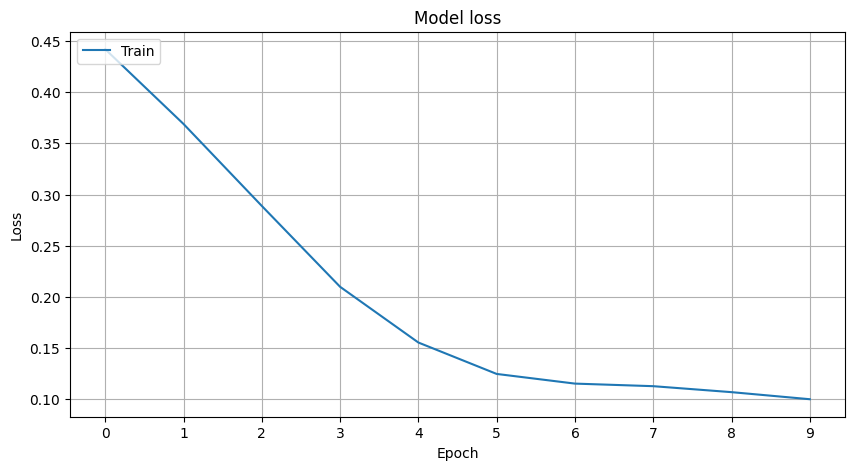

In [40]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["Train"], loc="upper left")
plt.grid()
plt.show()

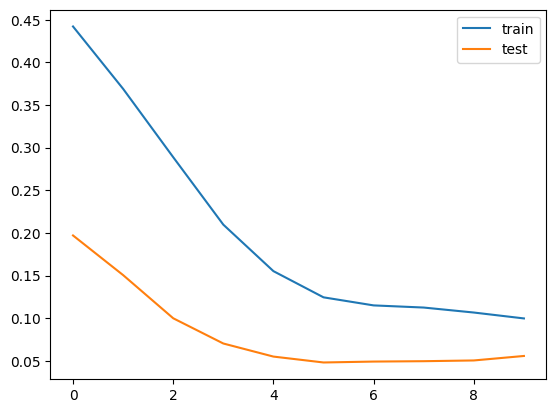

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
# import shap

# # we use the first 100 training examples as our background dataset to integrate over
# explainer = shap.DeepExplainer(model, x_train)
# shap_values = explainer.shap_values(x_test)

# Step #5 Evaluate Model Performance

In [43]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)
print(y_pred_scaled.shape)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test).reshape(-1, output_sequence_length)
print(y_pred.shape)
print(y_test_unscaled.shape)

2/2 [==============================] - 1s 5ms/step
(45, 5)
(45, 5)
(45, 5)


In [44]:
RMSE = math.sqrt( mean_squared_error(y_test_unscaled, y_pred))
print(f'Root MEAN Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')


# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')




Root MEAN Square Error(RMSE): 7.21
Mean Absolute Error (MAE): 6.15
Median Absolute Error (MAE): 6.15
Mean Absolute Percentage Error (MAPE): 1.57 %
Median Absolute Percentage Error (MDAPE): 1.5 %


# Plot Multiple Forcast (Most Complex Step)

In [45]:
def prepare_df(i, x, y, y_pred_unscaled):
    # Undo the scaling on x, reshape the testset into a one-dimensional array, so that it fits to the pred scaler
    x_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform((x[i]))[:,index_Close])\
    .rename(columns={0:'x_test'})
    
    y_test_unscaled_df = []
    # Undo the scaling on y
    if type(y) == np.ndarray:
        y_test_unscaled_df = pd.DataFrame(scaler_pred.inverse_transform(y)[i]).rename(columns={0:'y_test'})

    # Create a dataframe for the y_pred at position i, y_pred is already unscaled
    y_pred_df = pd.DataFrame(y_pred_unscaled[i]).rename(columns={0:'y_pred'})
    return x_test_unscaled_df, y_pred_df, y_test_unscaled_df


def plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title): 
    # Package y_pred_unscaled and y_test_unscaled into a dataframe with columns pred and true   
    if type(y_test_unscaled_df) == pd.core.frame.DataFrame:
        df_merge = y_pred_df.join(y_test_unscaled_df, how='left')
    else:
        df_merge = y_pred_df.copy()
    
    # Merge the dataframes 
    df_merge_ = pd.concat([x_test_unscaled_df, df_merge]).reset_index(drop=True)
    
    # Plot the linecharts
    fig, ax = plt.subplots(figsize=(20, 8))
    plt.title(title, fontsize=12)
    ax.set(ylabel = f"{asset_name}-{prediction_col}")
    sns.lineplot(data = df_merge_, linewidth=2.0, ax=ax)



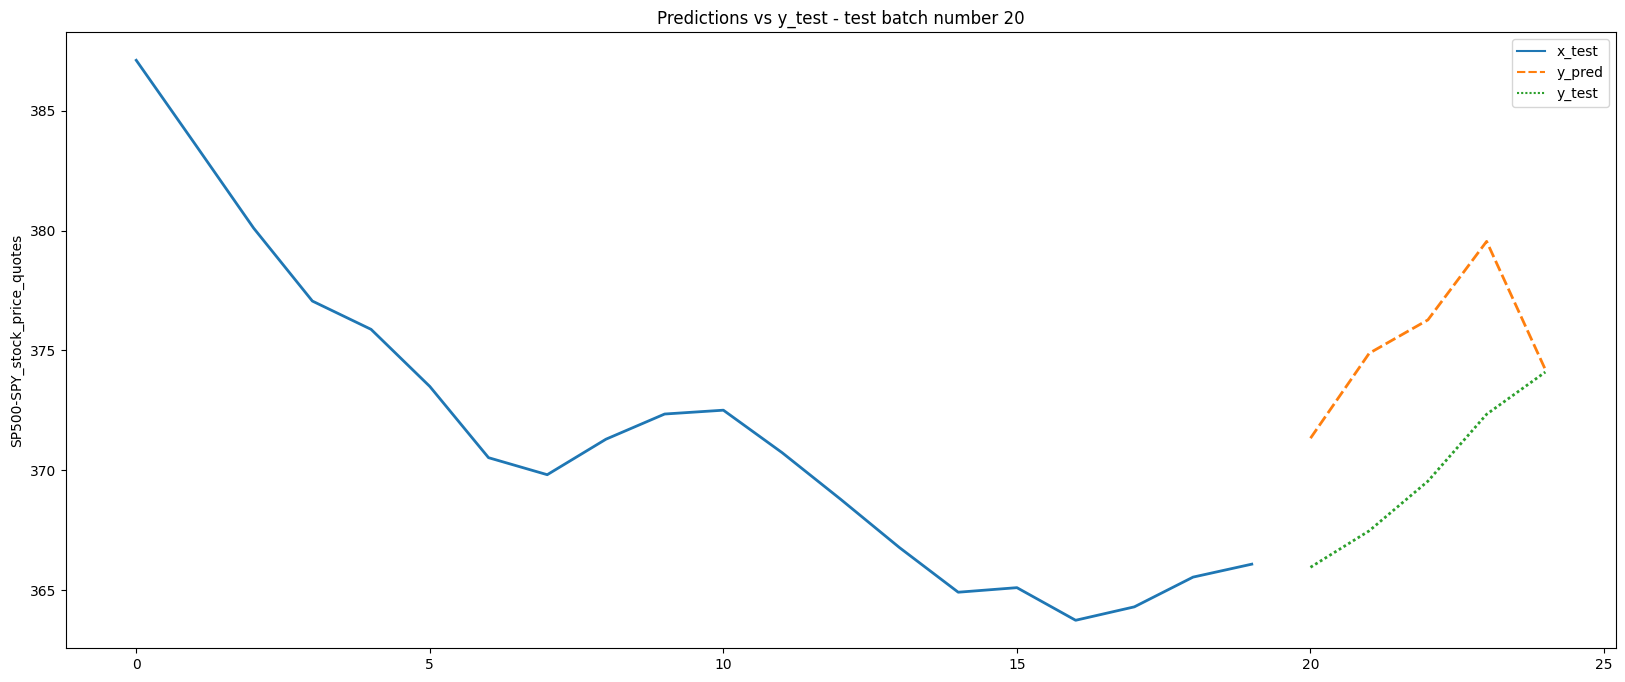

In [46]:
# Creates a linechart for a specific test batch_number and corresponding test predictions

x_test_unscaled_df, y_pred_df, y_test_unscaled_df = prepare_df(i, x_test, y_test, y_pred)
title = f"Predictions vs y_test - test batch number {input_sequence_length}"
plot_multi_test_forecast(x_test_unscaled_df, y_test_unscaled_df, y_pred_df, title) 

# Step #6 Create a new Forecast

In [47]:
x_test_latest_batch = np_scaled[-(input_sequence_length+1):-1,:].reshape(1,input_sequence_length,len(feature_cols))
print(f"{x_test_latest_batch.shape} is the latest input batch from the test dataset, which is contains the price values for the last {input_sequence_length} trading days")

    
x_test_latest_batch

(1, 20, 1) is the latest input batch from the test dataset, which is contains the price values for the last 20 trading days


array([[[0.32783019],
        [0.33944122],
        [0.3368106 ],
        [0.32519956],
        [0.31458636],
        [0.31095791],
        [0.30315675],
        [0.30605951],
        [0.31349782],
        [0.31522134],
        [0.30061684],
        [0.27812046],
        [0.25444485],
        [0.23584906],
        [0.23004354],
        [0.21616473],
        [0.20845428],
        [0.1996553 ],
        [0.18468795],
        [0.18359942]]])

In [48]:
y_pred_scaled = model.predict(x_test_latest_batch)
y_pred_unscaled = scaler_pred.inverse_transform(y_pred_scaled)
print(f"Predict on the inverse transformed batch {y_pred_unscaled.shape}")
print(y_pred_unscaled)

1/1 [==============================] - 0s 24ms/step
Predict on the inverse transformed batch (1, 5)
[[388.80173 391.02155 391.96924 395.23984 388.28128]]


In [49]:
print("Prepare the data and plot the input data and the predictions")
x_test_unscaled_df, y_test_unscaled_df, _ = prepare_df(0, x_test_latest_batch, '', y_pred_unscaled)
print(f"X-Test= {x_test_unscaled_df.shape}")
print(f"Y-Test= {y_test_unscaled_df.shape}")

# print(x_test_unscaled_df.tail(len(y_test_unscaled_df)))
# print(y_test_unscaled_df.tail(len(y_test_unscaled_df)))

Prepare the data and plot the input data and the predictions
X-Test= (20, 1)
Y-Test= (5, 1)


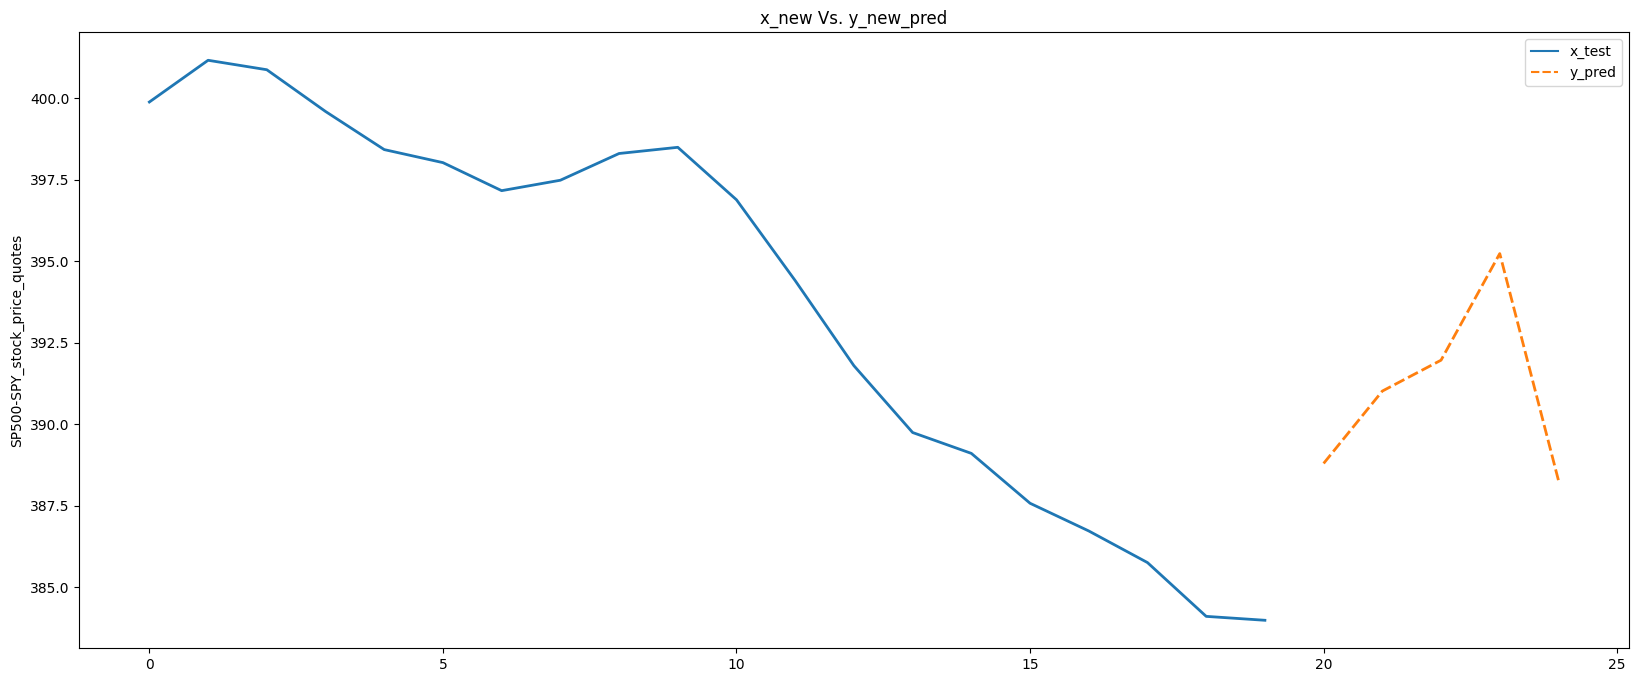

In [50]:
plot_multi_test_forecast(x_test_unscaled_df, '',y_test_unscaled_df, "x_new Vs. y_new_pred")

# Create Final Model

In [51]:
dfAll=df.sort_values(by=[date_col]).copy()
npAll_unscaled, npPredictCol_unscaled = prepare_data(dfAll) 
print(npAll_unscaled.shape,npPredictCol_unscaled.shape)

FEATURE LIST To Predict EMA1
['EMA1']
Convert the data to numpy values
(251, 1)
(251, 1)
(251, 1) (251, 1)


In [52]:
scalerFinalTrain = MinMaxScaler()
scalerFinalPred = MinMaxScaler()
npAll_scaled = scalerFinalTrain.fit_transform(npAll_unscaled)
npAllPredictCol_scaled = scalerFinalPred.fit_transform(npPredictCol_unscaled)
print(npAll_scaled.shape,npAllPredictCol_scaled.shape)
print(npAll_scaled[:2])
print(npAllPredictCol_scaled[:2])

(251, 1) (251, 1)
[[0.99283382]
 [1.        ]]
[[0.99283382]
 [1.        ]]


In [53]:

x_all, y_all = partition_dataset(input_sequence_length, output_sequence_length,npAll_scaled)
print(x_all.shape,y_all.shape)

(226, 20, 1) (226, 5)


In [54]:
history_final=model.fit(x=x_all, y=y_all, batch_size=n_batch_size, epochs=n_epochs,shuffle=False)

Epoch 1/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0894 - mean_absolute_error: 0.0894 - mean_squared_error: 0.0117
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0887 - mean_absolute_error: 0.0887 - mean_squared_error: 0.0116
Epoch 3/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0864 - mean_absolute_error: 0.0864 - mean_squared_error: 0.0111
Epoch 4/10
8/8 [==============================] - 0s 9ms/step - loss: 0.0849 - mean_absolute_error: 0.0849 - mean_squared_error: 0.0109
Epoch 5/10
8/8 [==============================] - 0s 11ms/step - loss: 0.0840 - mean_absolute_error: 0.0840 - mean_squared_error: 0.0107
Epoch 6/10
8/8 [==============================] - 0s 10ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - mean_squared_error: 0.0104
Epoch 7/10
8/8 [==============================] - 0s 8ms/step - loss: 0.0830 - mean_absolute_error: 0.0830 - mean_squared_error: 0.0105
Epoch 8/10
8/8 [==============================

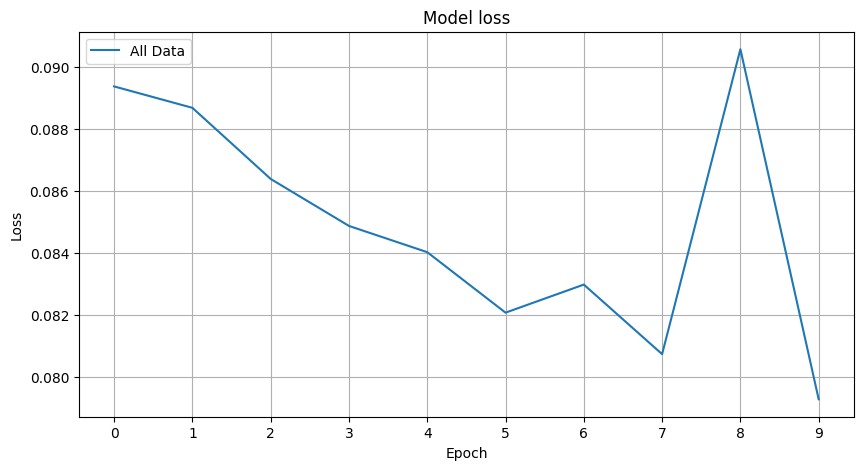

In [55]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
plt.plot(history_final.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epochs))
plt.legend(["All Data"], loc="upper left")
plt.grid()
plt.show()

In [56]:
print("Save model and scaler")
modelName=tune_folder
#modelName='test2022-20for10'
file_model=f'{model_path}/{modelName}.h5'
file_scaler=f'{model_path}/scaler_{modelName}.gz'
file_scaler_pred=f'{model_path}/scaler_pred_{modelName}.gz'

model.save(file_model)
# joblib.dump(scaler_train,file_scaler)
# joblib.dump(file_scaler_pred,file_scaler_pred)

joblib.dump(scalerFinalTrain,file_scaler)
joblib.dump(scalerFinalPred ,file_scaler_pred)

Save model and scaler


['models/scaler_pred_test2022-20for10.gz']